In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import uncertainties.unumpy as unp
from uncertainties import ufloat, correlated_values_norm, correlated_values, covariance_matrix, correlation_matrix
from iminuit import Minuit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import gvar

In [3]:
from academy.rates.BtoV import BtoV
from academy.formfactors.BGL import BToDStarBGL
from academy.formfactors.CLN import BToDStarCLN

In [4]:
tauBzero = 1.520e-12 * 1. / 6.582119e-16 / 1e-9
tauBplus = 1.638e-12 * 1. / 6.582119e-16 / 1e-9

# Inputs

We load more than we need for this example down below. But these code snippets to load the lattice data can be used later when implementing your own fits with lattice constraints.

## Fit Results

In [5]:
data = np.array(correlated_values(
    np.load("output/Unfolding/data/minv_central_values_full.npy"),
    np.load("output/Unfolding/data/minv_covariance_full.npy")
))

In [6]:
data_shape = np.array([
    *(data[ 0:10] / sum(data[ 0:10])),
    *(data[10:20] / sum(data[10:20])),
    *(data[20:30] / sum(data[20:30])),
    *(data[30:40] / sum(data[30:40])),
])

data_norm = np.array([
    (sum(data[ 0:10]) + sum(data[10:20])) / 2,
    (sum(data[20:30]) + sum(data[30:40])) / 2
])

## Lattice 2014

This is a single data point at zero-recoil for h_A1. https://arxiv.org/pdf/1403.0635.pdf

In [7]:
hA1_2014 = ufloat(0.906 , (0.004**2 + 0.012**2)**0.5)
hA1_2014

0.906+/-0.012649110640673518

In [8]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 19.5)

    ax.axvline(9.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.55+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

markers = {
    15: "v",
    16: "s",
    # (15, 16): "o",
    17: "o",
    18: "X",
    # (17, 18): "o"
    
}

bin_edges_wReco = np.array([*np.linspace(1.0, 1.45, num=10), 1.504]) 
bin_edges_costhetalReco = np.array([*np.linspace(-1, 1, num=11)])

bin_edges_all = { 
    "wReco": bin_edges_wReco,
    "costhetalReco": bin_edges_costhetalReco,
}

fit_vois = ["wReco", "costhetalReco"]

# Initialize and Use the eFFORT Class

Definitions of masses

In [9]:
m_Bzero = 5.27963
m_Bplus = 5.27932
m_Dstarzero = 2.00685
m_Dstarplus = 2.01026

Initialize a FF class, and then a rate class with our defined form factor.

In [10]:
lattice2 = gvar.gload("lattice_data/FitResults.PyDat")
#for x in lattice2:
#    print(f"{x} = {ufloat(gvar.mean(lattice2[x]), gvar.sdev(lattice2[x]))}")
    
lattice_coefficients = [
    lattice2["LQCD_a0"],
    lattice2["LQCD_a1"],
    lattice2["LQCD_a2"],
    lattice2["LQCD_b0"],
    lattice2["LQCD_b1"],
    lattice2["LQCD_b2"],
    lattice2["LQCD_c1"],
    lattice2["LQCD_c2"],
]

lattice_coefficients = correlated_values(
    gvar.mean(lattice_coefficients),
    gvar.evalcov(lattice_coefficients)
)

In [11]:
BzeroToDStarBGLLattice = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = lattice_coefficients[0:3],
    exp_coeff_b = lattice_coefficients[3:6],
    exp_coeff_c = lattice_coefficients[6:],
)

rate_lattice = BtoV(BzeroToDStarBGLLattice, Vcb=1)

Do the calculation first, then plot later.

In [12]:
w_edges = np.array([1.00000001, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.503549794359789])
cosTheteaL_edges = np.linspace(-1, 1, 11)

In [13]:
w_range = np.linspace(*rate_lattice.FF.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*rate_lattice.FF.kinematics.cosL_range)

In [14]:
total_rate_lattice = rate_lattice.Gamma()
w_rate_lattice = [rate_lattice.dGamma_dw(w) / total_rate_lattice       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate_lattice = [rate_lattice.dGamma_dcosL(w) / total_rate_lattice * (max(cosL_range) - min(cosL_range)) for w in cosL_range]

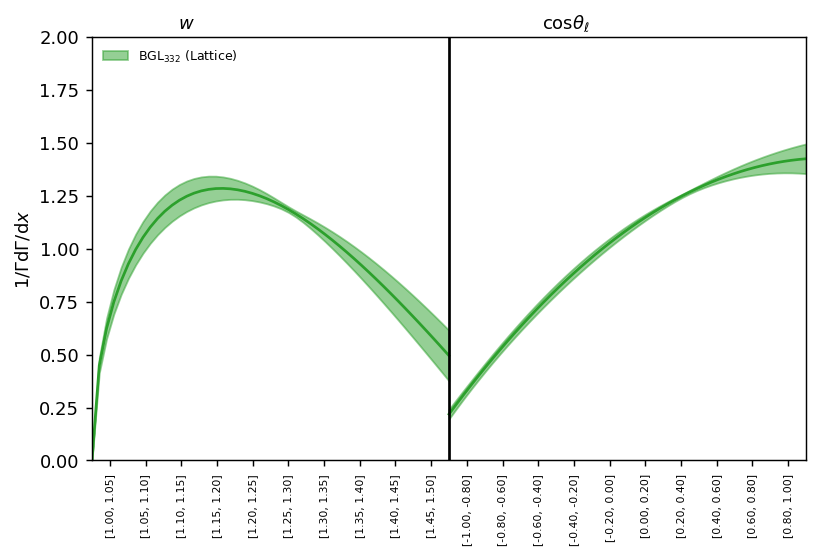

In [15]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_lattice), color="tab:green")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_lattice) + unp.std_devs(w_rate_lattice),
    unp.nominal_values(w_rate_lattice) - unp.std_devs(w_rate_lattice),
    alpha=0.5, color="tab:green", label=r"BGL$_{332}$ (Lattice)"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_lattice), color="tab:green")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_lattice) + unp.std_devs(cosL_rate_lattice),
    unp.nominal_values(cosL_rate_lattice) - unp.std_devs(cosL_rate_lattice),
    alpha=0.5, color="tab:green"
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
plt.tight_layout()
plt.show()
plt.close()

# Fitting The Spectrum

## Calculate a Prediction

First exercise: Plot the prediction for the rate in bins of w, cosThetaL, cosThetaV, and chi. This can be used later when implementing your chi2 fit.

Let us initialize a new class for fitting, where we will vary the coefficients away from the lattice coefficients. As starting values, use the lattice

In [16]:
BzeroToDStarBGLFit = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = unp.nominal_values(lattice_coefficients[0:3]),
    exp_coeff_b = unp.nominal_values(lattice_coefficients[3:6]),
    exp_coeff_c = unp.nominal_values(lattice_coefficients[6:]),
)

rate_fit = BtoV(BzeroToDStarBGLFit, Vcb=1)

In [17]:
# Integration close to the boundaries is problematic, hence we go epsilon away from it
BzeroToDStarBGLFit.kinematics.w_range_numerical_stable

(1.00000001, 1.503549794359789)

In [18]:
def prediction_shape(x):
    """Make a prediction for the shape given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    total_rate = rate_fit.Gamma()
    prediction = np.array([
        [rate_fit.DGamma_Dw(l, u) / (u-l) * (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])],
        [rate_fit.DGamma_DcosL(l, u) / (u-l) * (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])],
    ]).flatten() / total_rate
    
    # Calculate the prediction in 20 bins, 10 for w, 10 for cosThetaL
    return prediction

In [19]:
x0 = np.array([*lattice_coefficients, 0, 1])  # [a0, a1, a2, b0, b1, b2, c1, c2, c3=0, Vcb=1]
myPrediction = prediction_shape(x0)

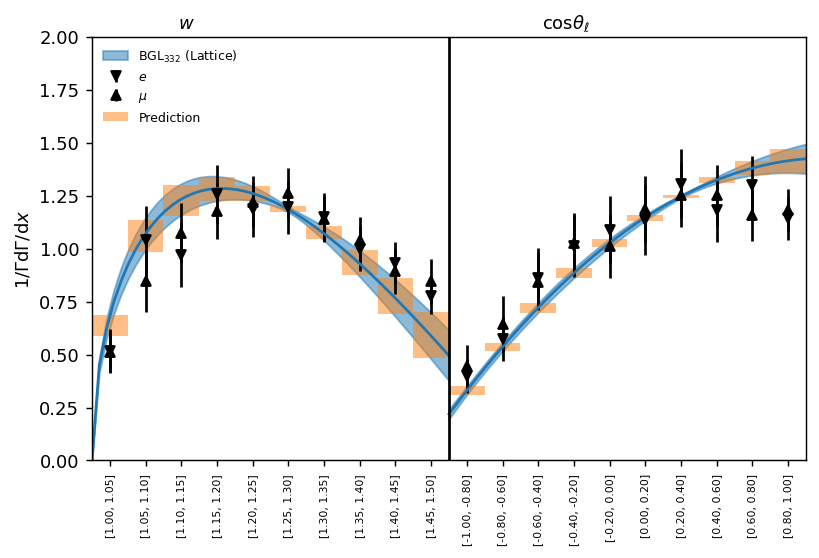

In [20]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.errorbar(
    range(0, 10),
    y=unp.nominal_values(data_shape[ 0:10]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    yerr=unp.std_devs(data_shape[ 0:10]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    marker="v", ls="", color="black", label=r"$e$"
)

ax.errorbar(
    range(10, 20),
    y=unp.nominal_values(data_shape[10:20]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    yerr=unp.std_devs(data_shape[10:20]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    marker="v", ls="", color="black"
)


ax.errorbar(
    range(0, 10),
    y=unp.nominal_values(data_shape[20:30]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    yerr=unp.std_devs(data_shape[20:30]) / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])]),
    marker="^", ls="", color="black", label=r"$\mu$"
)

ax.errorbar(
    range(10, 20),
    y=unp.nominal_values(data_shape[30:40]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    yerr=unp.std_devs(data_shape[30:40]) / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]),
    marker="^", ls="", color="black"
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_lattice), color="tab:blue")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_lattice) + unp.std_devs(w_rate_lattice),
    unp.nominal_values(w_rate_lattice) - unp.std_devs(w_rate_lattice),
    alpha=0.5, color="tab:blue", label=r"BGL$_{332}$ (Lattice)"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_lattice), color="tab:blue")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_lattice) + unp.std_devs(cosL_rate_lattice),
    unp.nominal_values(cosL_rate_lattice) - unp.std_devs(cosL_rate_lattice),
    alpha=0.5, color="tab:blue"
)

ax.bar(range(20), width=1, bottom=unp.nominal_values(myPrediction) - unp.std_devs(myPrediction), height=2*unp.std_devs(myPrediction), color="tab:orange", alpha=0.5, label="Prediction")

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
plt.tight_layout()
plt.show()
plt.close()

In [21]:
def prediction_rate(x):
    """Make a prediction for the absolute rate given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    return rate_fit.Gamma()

In [22]:
def prediction_form_factor(x):
    """Make a prediction for hA1 given the coefficients and Vcb.
    
    x = [a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]
    """
    rate_fit.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    rate_fit.Vcb = x[-1]
    return rate_fit.FF.h_A1(1)

## Exercise: Chi2 for Vcb and FF Extraction

Next we need to implement our chi2 function. It has the form

$\chi^2 = \chi^2_\mathrm{Shape} + \chi^2_\mathrm{Norm} + \chi^2_\mathrm{Lattice}$

We calculated the shape already, so let us start with that one.

Make use of the following already defined functions:
* `prediction_shape` Calculates the shape in 20 bins. You have to delete the same two bins as are deleted in the data shape
* `prediction_rate` Calculates the absolute rate (norm)
* `prediction_form_factor` Calculate the form factor hA1 at w=1

In [23]:
data_norm_fit = data_norm[0]  # only electron

In [24]:
print("mu=", data_norm_fit.n, "sigma=", data_norm_fit.s)

mu= 2.2132597594625827e-14 sigma= 5.943790963965155e-16


In [25]:
data_shape_fit = data_shape[:20]  # only electron
data_shape_fit = np.array([  # here we just rescale everything to the same normalization
    *(data_shape[ 0:10] / np.array([(u-l) / (w_edges[-1] - w_edges[0]) for l, u in zip(w_edges, w_edges[1:])])),
    *(data_shape[10:20] / np.array([(u-l) / (cosTheteaL_edges[-1] - cosTheteaL_edges[0]) for l, u in zip(cosTheteaL_edges, cosTheteaL_edges[1:])]))
])
# Delete 100% correlated values
data_shape_fit = np.delete(data_shape_fit, 19)
data_shape_fit = np.delete(data_shape_fit,  9)

In [26]:
data_shape_covariance_fit = np.array(covariance_matrix(data_shape_fit))
shape_Cinv = np.linalg.inv(data_shape_covariance_fit)  # Just do it once because it is computational expensive
data_shape_fit = np.array(unp.nominal_values(data_shape_fit))

In [27]:
def chi2(a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb):
    x = np.array([a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb])
    
    # Useful variabales here:
    # data_shape_fit
    # shape_Cinv
    # data_norm_fit
    # hA1_2014
    
    prediction = prediction_shape(x)
    prediction = np.delete(prediction, 19)
    prediction = np.delete(prediction,  9)
    delta = prediction - data_shape_fit
    chi2_shape = delta.transpose() @ shape_Cinv @ delta
    
    chi2_norm = (data_norm_fit.n - prediction_rate(x)) ** 2 / data_norm_fit.s **2
    
    chi2_lattice = (hA1_2014.n - prediction_form_factor(x)) ** 2 / hA1_2014.s ** 2

    return chi2_norm + chi2_lattice + chi2_shape

In [28]:
# Example execution with some values for the form factor coefficients and Vcb
chi2(*unp.nominal_values(lattice_coefficients), 0, 40e-3)

111.22718128342498

Number of coefficients for each form factor. Right now we use the numbers given by the lattice, but depending on the sensitivity of the data, the number of parameters has to be decreased to prevent overfitting.

In [29]:
a = 2
b = 2
c = 1

In [30]:
m = Minuit(chi2, 
    a0=lattice_coefficients[0].n if a >= 1 else 0,
    a1=lattice_coefficients[1].n if a >= 2 else 0,
    a2=lattice_coefficients[2].n if a >= 3 else 0,
    b0=lattice_coefficients[3].n if b >= 1 else 0,
    b1=lattice_coefficients[4].n if b >= 2 else 0,
    b2=lattice_coefficients[5].n if b >= 3 else 0,
    c1=lattice_coefficients[6].n if c >= 1 else 0,
    c2=lattice_coefficients[7].n if c >= 2 else 0,
    c3=0,
    Vcb=40e-3,
  )

m.fixed["a0"] = True if a <= 0 else False
m.fixed["b0"] = True if b <= 0 else False
m.fixed["c1"] = True if c <= 0 else False

m.fixed["a1"] = True if a <= 1 else False
m.fixed["b1"] = True if b <= 1 else False
m.fixed["c2"] = True if c <= 1 else False

m.fixed["a2"] = True if a <= 2 else False
m.fixed["b2"] = True if b <= 2 else False
m.fixed["c3"] = True if c <= 2 else False

m.simplex()
m.migrad() 
m.hesse()  
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.143                      │              Nfcn = 370              │
│ EDM = 0.00012 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │   0.03    │   0.04    │            │            │         │         │       │
│ 1 │ a1   │   -0.1    │    1.2    │            │            │         │         │       │
│ 2 │ a2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 3 │ b0   │ 13.12e-3  │  0.18e-3  │            │            │         │         │       │
│ 4 │ b1   │   0.02    │   0.07    │            │            │         │         │       │
│ 5 │ b2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 6 │ c1   │   0.003   │   0.005   │            │            │         │         │       │
│ 7 │ c2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 8 │ c3   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 9 │ Vcb  │  0.0391   │  0.0033   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │        a0        a1        a2        b0        b1        b2        c1        c2        c3       Vcb │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  a0 │    0.0013   -0.0448         0  7.55e-08   0.00179         0  0.000169         0         0 -9.77e-05 │
│  a1 │   -0.0448      1.56         0 -4.62e-07   -0.0631         0  -0.00578         0         0   0.00336 │
│  a2 │         0         0         0         0         0         0         0         0         0         0 │
│  b0 │  7.55e-08 -4.62e-07         0  3.36e-08  7.25e-08         0  7.86e-09         0         0 -1.01e-07 │
│  b1 │   0.00179   -0.0631         0  7.25e-08   0.00461         0  0.000267         0         0 -0.000204 │
│  b2 │         0         0         0         0         0         0         0         0         0         0 │
│  c1 │  0.000169  -0.00578         0  7.86e-09  0.000267         0  2.82e-05         0         0 -1.57e-05 │
│  c2 │         0         0         0         0         0         0         0         0         0         0 │
│  c3 │         0         0         0         0         0         0         0         0         0         0 │
│ Vcb │ -9.77e-05   0.00336         0 -1.01e-07 -0.000204         0 -1.57e-05         0         0  1.08e-05 │
└─────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘